# Multi Task Neural Networks Recommendation Model

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F
import pandas as pd
import numpy as np
import itertools

### Loading Dataset

In [17]:
data = pd.read_csv("./ratings_with_watch_time.csv")

<AxesSubplot:>

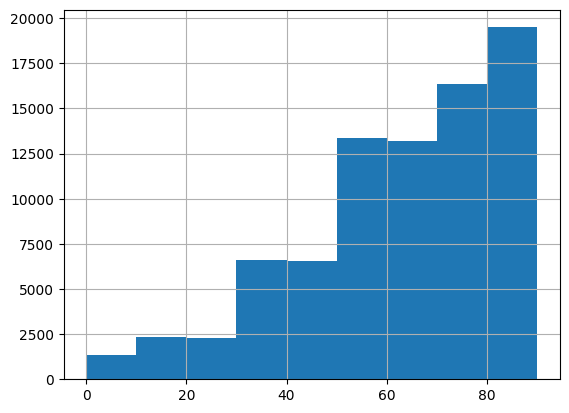

In [106]:
data['watch_time'].hist(bins=range(0,100,10))

In [22]:
data.head()

,userId,movieId,rating,timestamp,watch_time
0,1,1,4.0,964982703,97.151518
1,1,3,4.0,964981247,79.113979
2,1,6,4.0,964982224,96.793664
3,1,47,5.0,964983815,78.785229
4,1,50,5.0,964982931,80.947069


In [23]:
data['userId'] = data['userId'] - 1
data['movieId'] = data['movieId'] - 1

In [24]:
data.drop_duplicates(inplace=True)

In [25]:
data.dropna(inplace=True)

In [26]:
def fillID(df, col):
    m = dict({-1:-1})
    new_col = []
    for value in df[col].values:
        if value in m:
            new_col.append(m[value])
        else:
            new_index = max(m.values()) + 1
            m[value] = new_index
            new_col.append(new_index)
    df[col+"Index"] = new_col
    return

In [27]:
fillID(data, 'userId')
fillID(data, 'movieId')

### Converting Continous Rating to Class

In [29]:
# data['rating] = normalize(data['rating'].values)
def get_class(x):
    if x < 4.0:
        return 0
    return 1
data['rating'] = data['rating'].apply(lambda x: get_class(x))

In [30]:
data['rating'].value_counts()

0    52256
1    48580
Name: rating, dtype: int64

### Train/Test Splitting

In [31]:
np.random.seed(3)
msk = np.random.rand(len(data)) < 0.8 # 80% Train, 20% Test
train = data[msk].copy()
validation = data[~msk].copy()

In [32]:
len(data), len(train), len(validation)

(100836, 80450, 20386)

In [33]:
train.columns

Index(['userId', 'movieId', 'rating', 'timestamp', 'watch_time', 'userIdIndex',
       'movieIdIndex'],
      dtype='object')

In [34]:
num_users = data['userIdIndex'].nunique()
num_movies = data['movieIdIndex'].nunique()

In [35]:
print(num_users, num_movies)

610 9724


In [36]:
train.head()

,userId,movieId,rating,timestamp,watch_time,userIdIndex,movieIdIndex
0,0,0,1,964982703,97.151518,0,0
1,0,2,1,964981247,79.113979,0,1
2,0,5,1,964982224,96.793664,0,2
3,0,46,1,964983815,78.785229,0,3
6,0,100,1,964980868,96.250136,0,6


### Dataset and Dataloader

In [39]:
batch_size = 5000

train_features = torch.LongTensor(train[['userIdIndex', 'movieIdIndex']].values)
train_target = torch.Tensor(train[['rating', 'watch_time']].values).float()

train_ds = TensorDataset(train_features, train_target)
dl_train = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4)

val_features = torch.LongTensor(validation[['userIdIndex', 'movieIdIndex']].values)
val_target = torch.Tensor(validation[['rating','watch_time']].values).float()

val_ds = TensorDataset(val_features, val_target)
dl_val = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, drop_last=True)

In [40]:
xb, yb = next(iter(dl_train))
print(xb)
print(yb)

tensor([[ 572, 2315],
        [ 609, 1133],
        [ 413, 5335],
        ...,
        [ 476, 2999],
        [ 317, 3490],
        [  67, 1911]])
tensor([[ 1.0000, 86.0964],
        [ 1.0000, 92.7592],
        [ 0.0000, 71.1582],
        ...,
        [ 1.0000, 84.3698],
        [ 0.0000, 71.9219],
        [ 1.0000, 87.3280]])


### Two Tower Model

![alt text](model.png "Two Tower Model")

### Tower

In [45]:
# Towers Model

class MultiTaskNetwork(nn.Module):
    def __init__(self, num_users, num_items, emb_size=64):
        super(MultiTaskNetwork, self).__init__()
        self.user_embedding = nn.Embedding(num_users, emb_size)
        self.user_embedding.weight.data.uniform_(0, 0.05)
        
        self.item_embedding = nn.Embedding(num_items, emb_size)
        self.item_embedding.weight.data.uniform_(0, 0.05)
        
        
        # FC layers
        self.fc1 = nn.Linear(emb_size*2, emb_size)
        self.fc2 = nn.Linear(emb_size, emb_size//2)
        
        # Task - 1
        self.task_1_l1 = nn.Linear(emb_size//2, emb_size//2)
        self.task_1_l2 = nn.Linear(emb_size//2, 1)
        
        # Task - 2
        self.task_2_l1 = nn.Linear(emb_size//2, emb_size//2)
        self.task_2_l2 = nn.Linear(emb_size//2, 1)
    
    def forward(self, user, item):
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)
        
        emb = torch.cat([user_emb, item_emb], dim=1)
        out = nn.functional.relu(self.fc1(emb))
        out = nn.functional.relu(self.fc2(out))
        
        # Task-1
        out1 = nn.functional.relu(self.task_1_l1(out))
        out1 = nn.functional.sigmoid(self.task_1_l2(out))
        
        # Task-2
        out2 = nn.functional.relu(self.task_2_l1(out))
        out2 = self.task_2_l2(out)
        
        return out1, out2
        

In [49]:
t1 = MultiTaskNetwork(610, 9724)
t1(torch.Tensor([5]).long(), torch.Tensor([5]).long())

(tensor([[0.4768]], grad_fn=<SigmoidBackward0>),
 tensor([[0.1301]], grad_fn=<AddmmBackward0>))

### Test Method

In [54]:
def test(model):
    model.eval()
    
    total_loss = []
    for indices, labels in dl_val:
        ratings = labels[:,0]
        watch_time = labels[:,1]
        users, items = indices[:,0], indices[:,1]
        # Compute model output
        outputs = model(users, items)
        probability = outputs[0]
        watch_time_estimate = outputs[1]
        bce_loss = F.binary_cross_entropy(probability, ratings.unsqueeze(1))
        mse_loss = F.mse_loss(watch_time_estimate, watch_time.unsqueeze(1))
        final_loss = mse_loss + bce_loss
        total_loss.append(final_loss.item())
    
    print(f"Test Loss: {sum(total_loss) / len(total_loss)}")

In [55]:
test(t1)

Test Loss: 5227.088439941406


### Training Loop

In [64]:
def trainer(model, num_epochs, optimizer):
    # Set model in Training mode
    model.train()
    
    # Start training loop
    for epoch in range(num_epochs):
        total_loss = []
        for indices, labels in dl_train:
            ratings = labels[:,0]
            watch_time = labels[:,1]
            users, items = indices[:,0], indices[:,1]
            # Compute model output
            outputs = model(users, items)
            probability = outputs[0]
            watch_time_estimate = outputs[1]
            bce_loss = F.binary_cross_entropy(probability, ratings.unsqueeze(1))
            mse_loss = F.mse_loss(watch_time_estimate, watch_time.unsqueeze(1))
            loss = mse_loss + bce_loss

            # Update model weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss.append(loss.item())
        
        # Print Error
        print(f"{epoch}/{num_epochs} - Loss: {sum(total_loss)/len(total_loss)}")
        
        # Test model at regular intervals
        if epoch % 10 == 0:
            # Test model
            test(model)
        

### Initialize Model

In [65]:
multi_task_model = MultiTaskNetwork(610, 9724)

In [66]:
# Init optimizer
optimizer = torch.optim.Adam(multi_task_model.parameters(), lr=0.01)

### Training

In [95]:
trainer(multi_task_model, 10, optimizer)

0/10 - Loss: 316.6365769330193
Test Loss: 308.6518840789795
1/10 - Loss: 319.15116074505977
2/10 - Loss: 317.87035414751836
3/10 - Loss: 315.7685008329504
4/10 - Loss: 314.6537457634421
5/10 - Loss: 315.21390847598803
6/10 - Loss: 316.05054249483
7/10 - Loss: 317.171677533318
8/10 - Loss: 313.20897001378677
9/10 - Loss: 315.7939058191636


In [96]:
test(multi_task_model)

Test Loss: 303.41742515563965


### Sanity Checks

In [97]:
indices, labels = next(iter(dl_val))
ratings = labels[:,0]
watch_time = labels[:,1]
users, items = indices[:,0], indices[:,1]
# Compute model output
outputs = multi_task_model(users, items)
probability = outputs[0]
watch_time_estimate = outputs[1]
bce_loss = F.binary_cross_entropy(probability, ratings.unsqueeze(1))
mse_loss = F.mse_loss(watch_time_estimate, watch_time.unsqueeze(1))
final_loss = mse_loss + bce_loss
print(f"final loss: {final_loss.item()}")

final loss: 301.3646240234375


In [98]:
ratings.unsqueeze(1)

tensor([[0.],
        [1.],
        [0.],
        ...,
        [1.],
        [0.],
        [0.]])

In [99]:
watch_time.unsqueeze(1)

tensor([[13.0558],
        [96.8300],
        [63.0757],
        ...,
        [97.3810],
        [12.1854],
        [51.4842]])

In [100]:
probability

tensor([[1.8048e-06],
        [6.2872e-01],
        [5.6661e-01],
        ...,
        [5.9210e-01],
        [3.9318e-01],
        [4.6515e-01]], grad_fn=<SigmoidBackward0>)

In [101]:
watch_time_estimate

tensor([[14.2858],
        [86.4961],
        [76.4846],
        ...,
        [80.6722],
        [60.5692],
        [65.4123]], grad_fn=<AddmmBackward0>)

### Compute Accuracy for Batch

In [102]:
threshold = 0.5

# Convert to class labels
class_labels = (probability > threshold).int()

In [103]:
class_labels

tensor([[0],
        [1],
        [1],
        ...,
        [1],
        [0],
        [0]], dtype=torch.int32)

In [104]:
correct_predictions = (class_labels == ratings.unsqueeze(1)).sum().item()
total_samples = ratings.size(0)
accuracy = correct_predictions / total_samples * 100

print("Accuracy:", accuracy, "%")

Accuracy: 71.74000000000001 %


In [105]:
watch_time_difference = torch.abs(watch_time.unsqueeze(1) - watch_time_estimate).sum().item() / 5000
print(f"Average Watch Time Error: {watch_time_difference}")

Average Watch Time Error: 13.3471140625
